In [ ]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy

In [2]:
import tweepy
import pandas as pd
from nltk.stem.porter import *
from wordcloud import WordCloud
import numpy as np
import os.path
import re

## Questions we are looking to answer about the Farmers Protest in India:
1) General sentiments of people - are they in favour of the Farm Bill or not - Classification. <br>
2) What are their main concerns - NER

## Dev Notes (for the group), delete this later
Regson (Preprocessing):
1) I only used the tweets which has not been truncated in the api - this means we are not actually working with 1000 tweets. We can increase max_items later to use more. <br>
2) I removed the all hashtags from tweets, but it might be useful keep them and just remove the "#" instead. The hash tag itself could hold some sentiment, this will need to be expiremented. <br>
3) I  removed stemmings, but im not sure how good this stemmings libaries is, we can give it a try with / without the stemming libiary and see what performs better? <br>
4) I removed the search terms "farmer" & "protest", because nearly every tweet contained this. <br>
5) I removed all non-ASCII text, this removed emojis and words written in hindi - I'm not sure if the sentiment libaries supports unicode but some emojis will definitely hold sentiment.  <br>

## Set up config information

In [3]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-3-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [ ]:
USE_CSV = True

if not USE_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 1000
    result_type = "recent"
    lang = "en"
    # Do not include retweets or replies          
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets -filter:replies",
                             result_type=result_type, lang=lang).items(max_items)

    # Extract only the required keys from the response
    # Do not include truncated tweets
    tweets = [
        [tweet.created_at,
         tweet.text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified
        ] for tweet in response if (not tweet.truncated) ]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [ ]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Truncated tweets were removed in the prior cell

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,:\\.!?|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert text to lower case
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too, we may need this 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove the search terms 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('farmer', '', x))
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('protest', '', x))

# Remove any hashtags
# (!) NOTE: it might be possible that someone uses hashtag in midtext, so might need this
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
min_word_length = 3
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove stemmings
# (?) NOTE: Maybe use a different stemming libary or keep stemmings
stemmer = PorterStemmer()
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

 ## Word Cloud

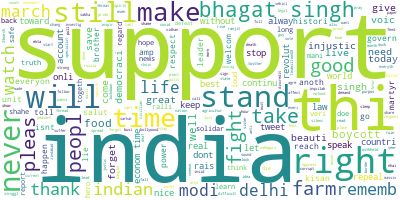

In [4]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

In [5]:
# tweets_df['text_processed'] is the processed text 
# tweets_df['text'] is the original tweet